inspect normal AK4CHS jet and relation with leptonjet to supress QCD multijet

In [1]:
from coffea import hist
import coffea.processor as processor
from coffea.analysis_objects import JaggedCandidateArray
import numpy as np
import matplotlib.pyplot as plt
import awkward
from FireHydrant.Tools.trigger import Triggers

np.seterr(divide='ignore', invalid='ignore', over='ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import json
dataset4mu_ = json.load(open('../Samples/signal_4mu.json'))
dataset2mu2e_ = json.load(open('../Samples/signal_2mu2e.json'))
qcd_ = json.load(open('../Samples/QCD_Pt-120To170_MuEnriched.json'))

In [39]:
class ak4chsprocessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        channel_axis = hist.Cat('channel', 'channel')
        pt_axis = hist.Bin('pt', 'pT [GeV]', 50, 0, 100)
        maxpt_axis = hist.Bin('maxpt', 'pT [GeV]', 50, 0, 250)
        multi_axis = hist.Bin('multi', 'multiplicity', 10, 0, 10)
        ht_axis = hist.Bin('ht', 'HT [GeV]', 50, 0, 1000)
        hadHt_axis = hist.Bin('hadht', 'hadronic HT [GeV]', 50, 0, 1000)
        chaHadHt_axis = hist.Bin('chahadht', 'charged hadronic HT [GeV]', 50, 0, 1000)
        hovere_axis = hist.Bin('hovere', 'Had/EM', 50, 0, 2)
        dist_axis = hist.Bin('dist', 'distance', 50, 0, 1)
        ndau_axis = hist.Bin('multi', '# daughters', 50, 0, 50)
        fraction_axis = hist.Bin('frac', 'fraction', 50, 0, 1)
        cut_axis = hist.Bin('cut', 'pass cut', 2, 0, 2)
        ak4minpt_axis = hist.Cat('minpt', 'min ak4chs $p_T$ cut@0')
        self._accumulator = processor.dict_accumulator({
            'pt': hist.Hist('counts', dataset_axis, pt_axis, channel_axis),
            'maxpt': hist.Hist('Events', dataset_axis, maxpt_axis, channel_axis),
            'multi': hist.Hist('Events', dataset_axis, multi_axis, channel_axis),
            'ht': hist.Hist('Events', dataset_axis, ht_axis, channel_axis),
            'hadht': hist.Hist('Events', dataset_axis, hadHt_axis, channel_axis),
            'chahadht': hist.Hist('Events', dataset_axis, chaHadHt_axis, channel_axis),
            'hovere': hist.Hist('counts', dataset_axis, hovere_axis, channel_axis),
            'minhovere': hist.Hist('Events', dataset_axis, hovere_axis, channel_axis),
            'mindist': hist.Hist('Events', dataset_axis, dist_axis, channel_axis),
            'ndau': hist.Hist('Events', dataset_axis, ndau_axis, channel_axis),
            'hadfrac': hist.Hist('Events', dataset_axis, fraction_axis, channel_axis),
            'emfrac': hist.Hist('Events', dataset_axis, fraction_axis, channel_axis),
            'mufrac': hist.Hist('Events', dataset_axis, fraction_axis, channel_axis),
            'chadfrac': hist.Hist('Events', dataset_axis, fraction_axis, channel_axis),
            'cemfrac': hist.Hist('Events', dataset_axis, fraction_axis, channel_axis),
            'ak4chscut': hist.Hist('Events', dataset_axis, cut_axis, channel_axis, ak4minpt_axis),
        })
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset=df['dataset']
        triggermask = np.logical_or.reduce([df[tp] for tp in Triggers])
        
        ak4chs = JaggedCandidateArray.candidatesfromcounts(
            df['akjet_p4'],
            px=df['akjet_p4.fCoordinates.fX'],
            py=df['akjet_p4.fCoordinates.fY'],
            pz=df['akjet_p4.fCoordinates.fZ'],
            energy=df['akjet_p4.fCoordinates.fT'],
            jetid=df['akjet_jetid'],
            hadfr=df['akjet_hadronEnergyFraction'],
            chadfr=df['akjet_chaHadEnergyFraction'],
            emfr=df['akjet_emEnergyFraction'],
            cemfr=df['akjet_chaEmEnergyFraction'],
            mufr=df['akjet_muonEnergyFraction'],
            ndau=df['akjet_pfcands_n'],
        )
        ak4chs.add_attributes(hovere=ak4chs.hadfr/ak4chs.emfr,
                             chovere=ak4chs.chadfr/ak4chs.cemfr)
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        nmu = ((ljdautype==3)|(ljdautype==8)).sum()
        leptonjets.add_attributes(ismutype=(nmu>=2), iseltype=(nmu==0))
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        twomujets = dileptonjets.ismutype.sum()==2
        leadinglj = dileptonjets[dileptonjets.pt.argmax()]
        subleadinglj = dileptonjets[dileptonjets.pt.argsort()[:, 1:2]]
        fourMuChannel = twomujets&(leadinglj.ismutype.flatten())&(subleadinglj.ismutype.flatten())
        
        onemujets = dileptonjets.ismutype.sum()==1
        twoMuTwoEChannel = onemujets&(leadinglj.ismutype.flatten()|subleadinglj.ismutype.flatten())
        
        ak4chs = ak4chs[twoleptonjets]
        
        ljs = dileptonjets[twoMuTwoEChannel]
        ak4chs_ = ak4chs[twoMuTwoEChannel]
        jetid_ = (ak4chs_.jetid&(ak4chs_.pt>0)&(np.abs(ak4chs_.eta)<2.4)).sum()<=1
        output['ak4chscut'].fill(dataset=dataset, cut=jetid_.astype(int), channel='2mu2e', minpt='none')
        jetid_ = (ak4chs_.jetid&(ak4chs_.pt>20)&(np.abs(ak4chs_.eta)<2.4)).sum()<=1
        output['ak4chscut'].fill(dataset=dataset, cut=jetid_.astype(int), channel='2mu2e', minpt='20 GeV')
        jetid_ = (ak4chs_.jetid&(ak4chs_.pt>50)&(np.abs(ak4chs_.eta)<2.4)).sum()<=1
        output['ak4chscut'].fill(dataset=dataset, cut=jetid_.astype(int), channel='2mu2e', minpt='50 GeV')
        jetid_ = (ak4chs_.jetid&(ak4chs_.pt>100)&(np.abs(ak4chs_.eta)<2.4)).sum()<=1
        output['ak4chscut'].fill(dataset=dataset, cut=jetid_.astype(int), channel='2mu2e', minpt='100 GeV')
        
        ak4chs_ = ak4chs_[ak4chs_.jetid&(ak4chs_.pt>20)&(np.abs(ak4chs_.eta)<2.4)]
        
        output['multi'].fill(dataset=dataset, multi=ak4chs_.counts, channel='2mu2e')
        output['pt'].fill(dataset=dataset, pt=ak4chs_.pt.flatten(), channel='2mu2e')
        threeakjets = ak4chs_[ak4chs_.counts>2]
        thirdptidx = threeakjets.pt.argsort()[:, 2:3]
        thirdpt = threeakjets.pt[thirdptidx]
        output['maxpt'].fill(dataset=dataset, maxpt=thirdpt.flatten(), channel='2mu2e')
        output['ht'].fill(dataset=dataset, ht=ak4chs_.p4.pt.sum(), channel='2mu2e')
        output['hadht'].fill(dataset=dataset, hadht=(ak4chs_.p4.pt*ak4chs_.hadfr).sum(), channel='2mu2e')
        output['chahadht'].fill(dataset=dataset, chahadht=(ak4chs_.p4.pt*ak4chs_.chadfr).sum(), channel='2mu2e')
        output['hovere'].fill(dataset=dataset, hovere=ak4chs_.hovere.flatten(), channel='2mu2e')
        output['minhovere'].fill(dataset=dataset, hovere=ak4chs_.hovere.min(), channel='2mu2e')
        output['ndau'].fill(dataset=dataset, multi=ak4chs_.ndau.flatten(), channel='2mu2e')
        output['hadfrac'].fill(dataset=dataset, frac=ak4chs_.hadfr.flatten(), channel='2mu2e')
        output['emfrac'].fill(dataset=dataset, frac=ak4chs_.emfr.flatten(), channel='2mu2e')
        output['mufrac'].fill(dataset=dataset, frac=ak4chs_.mufr.flatten(), channel='2mu2e')
        output['chadfrac'].fill(dataset=dataset, frac=ak4chs_.chadfr.flatten(), channel='2mu2e')
        output['cemfrac'].fill(dataset=dataset, frac=ak4chs_.cemfr.flatten(), channel='2mu2e')
        
        ljs = dileptonjets[fourMuChannel]
        ak4chs_ = ak4chs[fourMuChannel]
#         cleanmask = ak4chs_.match(ljs, deltaRCut=0.4)
        jetid_ = (ak4chs_.jetid&(ak4chs_.pt>0)&(np.abs(ak4chs_.eta)<2.4)).sum()==0
        output['ak4chscut'].fill(dataset=dataset, cut=jetid_.astype(int), channel='4mu', minpt='none')
        jetid_ = (ak4chs_.jetid&(ak4chs_.pt>20)&(np.abs(ak4chs_.eta)<2.4)).sum()==0
        output['ak4chscut'].fill(dataset=dataset, cut=jetid_.astype(int), channel='4mu', minpt='20 GeV')
        jetid_ = (ak4chs_.jetid&(ak4chs_.pt>50)&(np.abs(ak4chs_.eta)<2.4)).sum()==0
        output['ak4chscut'].fill(dataset=dataset, cut=jetid_.astype(int), channel='4mu', minpt='50 GeV')
        jetid_ = (ak4chs_.jetid&(ak4chs_.pt>100)&(np.abs(ak4chs_.eta)<2.4)).sum()==0
        output['ak4chscut'].fill(dataset=dataset, cut=jetid_.astype(int), channel='4mu', minpt='100 GeV')
        
        ak4chs_ = ak4chs_[ak4chs_.jetid&(ak4chs_.pt>20)&(np.abs(ak4chs_.eta)<2.4)]
        
        output['multi'].fill(dataset=dataset, multi=ak4chs_.counts, channel='4mu')
        output['pt'].fill(dataset=dataset, pt=ak4chs_.pt.flatten(), channel='4mu')
        threeakjets = ak4chs_[ak4chs_.counts>2]
        thirdptidx = threeakjets.pt.argsort()[:, 2:3]
        thirdpt = threeakjets.pt[thirdptidx]
        output['maxpt'].fill(dataset=dataset, maxpt=thirdpt.flatten(), channel='4mu')
        output['ht'].fill(dataset=dataset, ht=ak4chs_.p4.pt.sum(), channel='4mu')
        output['hadht'].fill(dataset=dataset, hadht=(ak4chs_.p4.pt*ak4chs_.hadfr).sum(), channel='4mu')
        output['chahadht'].fill(dataset=dataset, chahadht=(ak4chs_.p4.pt*ak4chs_.chadfr).sum(), channel='4mu')
        output['hovere'].fill(dataset=dataset, hovere=ak4chs_.hovere.flatten(), channel='4mu')
        output['minhovere'].fill(dataset=dataset, hovere=ak4chs_.hovere.min(), channel='4mu')
        output['ndau'].fill(dataset=dataset, multi=ak4chs_.ndau.flatten(), channel='4mu')
        output['hadfrac'].fill(dataset=dataset, frac=ak4chs_.hadfr.flatten(), channel='4mu')
        output['emfrac'].fill(dataset=dataset, frac=ak4chs_.emfr.flatten(), channel='4mu')
        output['mufrac'].fill(dataset=dataset, frac=ak4chs_.mufr.flatten(), channel='4mu')
        output['chadfrac'].fill(dataset=dataset, frac=ak4chs_.chadfr.flatten(), channel='4mu')
        output['cemfrac'].fill(dataset=dataset, frac=ak4chs_.cemfr.flatten(), channel='4mu')
#         leptonjets_ = dileptonjets[fourMuChannel]
#         filteredak4 = ak4chs#[(ak4chs.pt>20)&(ak4chs.chovere>1)]
#         ljXak4chs = leptonjets_.cross(filteredak4)
#         mindist = ljXak4chs.i0.p4.delta_r(ljXak4chs.i1.p4).min()
#         output['mindist'].fill(dataset=dataset, dist=mindist)
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

- 4mu channel

In [15]:
dataset={
    '4mu/mXX-100_mA-5_lxy-0p3': dataset4mu_['mXX-100_mA-5_lxy-0p3'],
    '4mu/mXX-1000_mA-0p25_lxy-0p3': dataset4mu_['mXX-1000_mA-0p25_lxy-0p3'],
    '4mu/mXX-100_mA-5_lxy-300': dataset4mu_['mXX-100_mA-5_lxy-300'],
    '4mu/mXX-1000_mA-0p25_lxy-300': dataset4mu_['mXX-1000_mA-0p25_lxy-300'],
    'QCD/pT120To170': qcd_['QCD_Pt-120To170'],
}

output = processor.run_uproot_job(dataset,
                                  treename="ffNtuplizer/ffNtuple",
                                  processor_instance=ak4chsprocessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 144/144 [00:26<00:00,  5.42items/s]


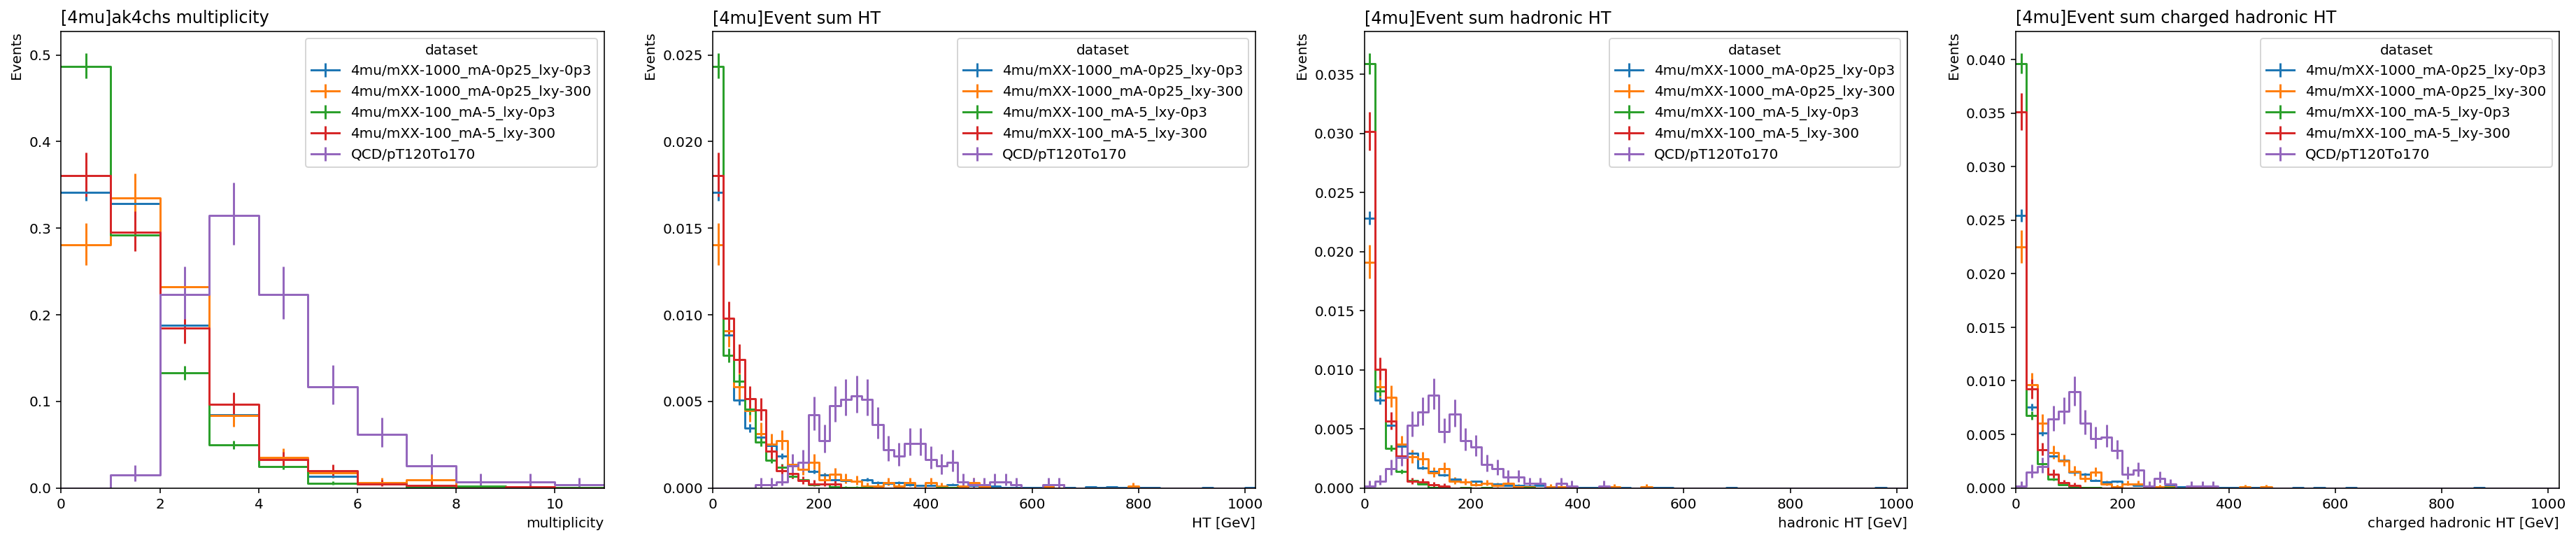

In [16]:
fig, axes = plt.subplots(1,4,figsize=(32,6))
hist.plot1d(output['multi'].integrate('channel', '4mu'), overlay='dataset', ax=axes[0], overflow='over', density=True)
# hist.plot1d(output['pt'], overlay='dataset', ax=axes[0][1], overflow='over', density=True)
# hist.plot1d(output['maxpt'], overlay='dataset', ax=axes[0][2], overflow='over', density=True)
hist.plot1d(output['ht'].integrate('channel', '4mu'), overlay='dataset', ax=axes[1], overflow='over', density=True)
hist.plot1d(output['hadht'].integrate('channel', '4mu'), overlay='dataset', ax=axes[2], overflow='over', density=True)
hist.plot1d(output['chahadht'].integrate('channel', '4mu'), overlay='dataset', ax=axes[3], overflow='over', density=True)

titles = [
    'ak4chs multiplicity',
#     'ak4chs $p_T$',
#     '3rd ak4chs $p_T$',
    'Event sum HT',
    'Event sum hadronic HT',
    'Event sum charged hadronic HT',
]
for i, ax in enumerate(axes.flat):
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.set_title('[4mu]'+titles[i], ha='left', x=0)

In [17]:
from collections import defaultdict
res = defaultdict(dict)
h = output['ak4chscut'].integrate('channel', '4mu')
for d in h.identifiers('dataset'):
    h_ = h.integrate('dataset', d)
    for c in h_.identifiers('minpt'):
        hh_ = h_.integrate('minpt', c)
        res[d][str(c)] = hh_.integrate('cut', slice(1,2)).values()[()]/hh_.integrate('cut').values()[()]*100
        res[d]['total'] = hh_.integrate('cut').values()[()]

import pandas as pd
df = pd.DataFrame(res).transpose()

df_ = df[['total', '20 GeV', '50 GeV', '100 GeV']]
df_.columns = ['total', '20 GeV (%)', '50 GeV (%)', '100 GeV (%)']
df_

,total,20 GeV (%),50 GeV (%),100 GeV (%)
4mu/mXX-1000_mA-0p25_lxy-0p3,3490.0,34.154728,66.361032,84.040115
4mu/mXX-1000_mA-0p25_lxy-300,513.0,28.070175,64.522417,85.380117
4mu/mXX-100_mA-5_lxy-0p3,2365.0,48.710359,76.448203,99.704017
4mu/mXX-100_mA-5_lxy-300,612.0,36.111111,83.169935,99.673203
QCD/pT120To170,273.0,0.000000,0.000000,13.553114


In [18]:
from collections import defaultdict
res = defaultdict(dict)
h = output['ht'].integrate('channel', '4mu')
for d in h.identifiers('dataset'):
    h_ = h.integrate('dataset', d)
    res[d]['total'] = h_.integrate('ht').values()[()]
    res[d]['200'] = h_.integrate('ht', slice(0,200)).values()[()]
    res[d]['250'] = h_.integrate('ht', slice(0,250)).values()[()]
import pandas as pd
df = pd.DataFrame(res).transpose()
df['eff@200'] = df['200']/df['total']
df['eff@250'] = df['250']/df['total']
df

/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/hist/hist_tools.py:477: RuntimeWarning: Reducing along axis <Bin (name=ht) instance at 0x7f3614673630>: requested stop 250 between bin boundaries, no interpolation is performed
  RuntimeWarning)


,200,250,total,eff@200,eff@250
4mu/mXX-1000_mA-0p25_lxy-0p3,3141.0,3258.0,3489.0,0.900258,0.933792
4mu/mXX-1000_mA-0p25_lxy-300,469.0,487.0,513.0,0.914230,0.949318
4mu/mXX-100_mA-5_lxy-0p3,2342.0,2359.0,2365.0,0.990275,0.997463
4mu/mXX-100_mA-5_lxy-300,606.0,612.0,612.0,0.990196,1.000000
QCD/pT120To170,42.0,111.0,273.0,0.153846,0.406593


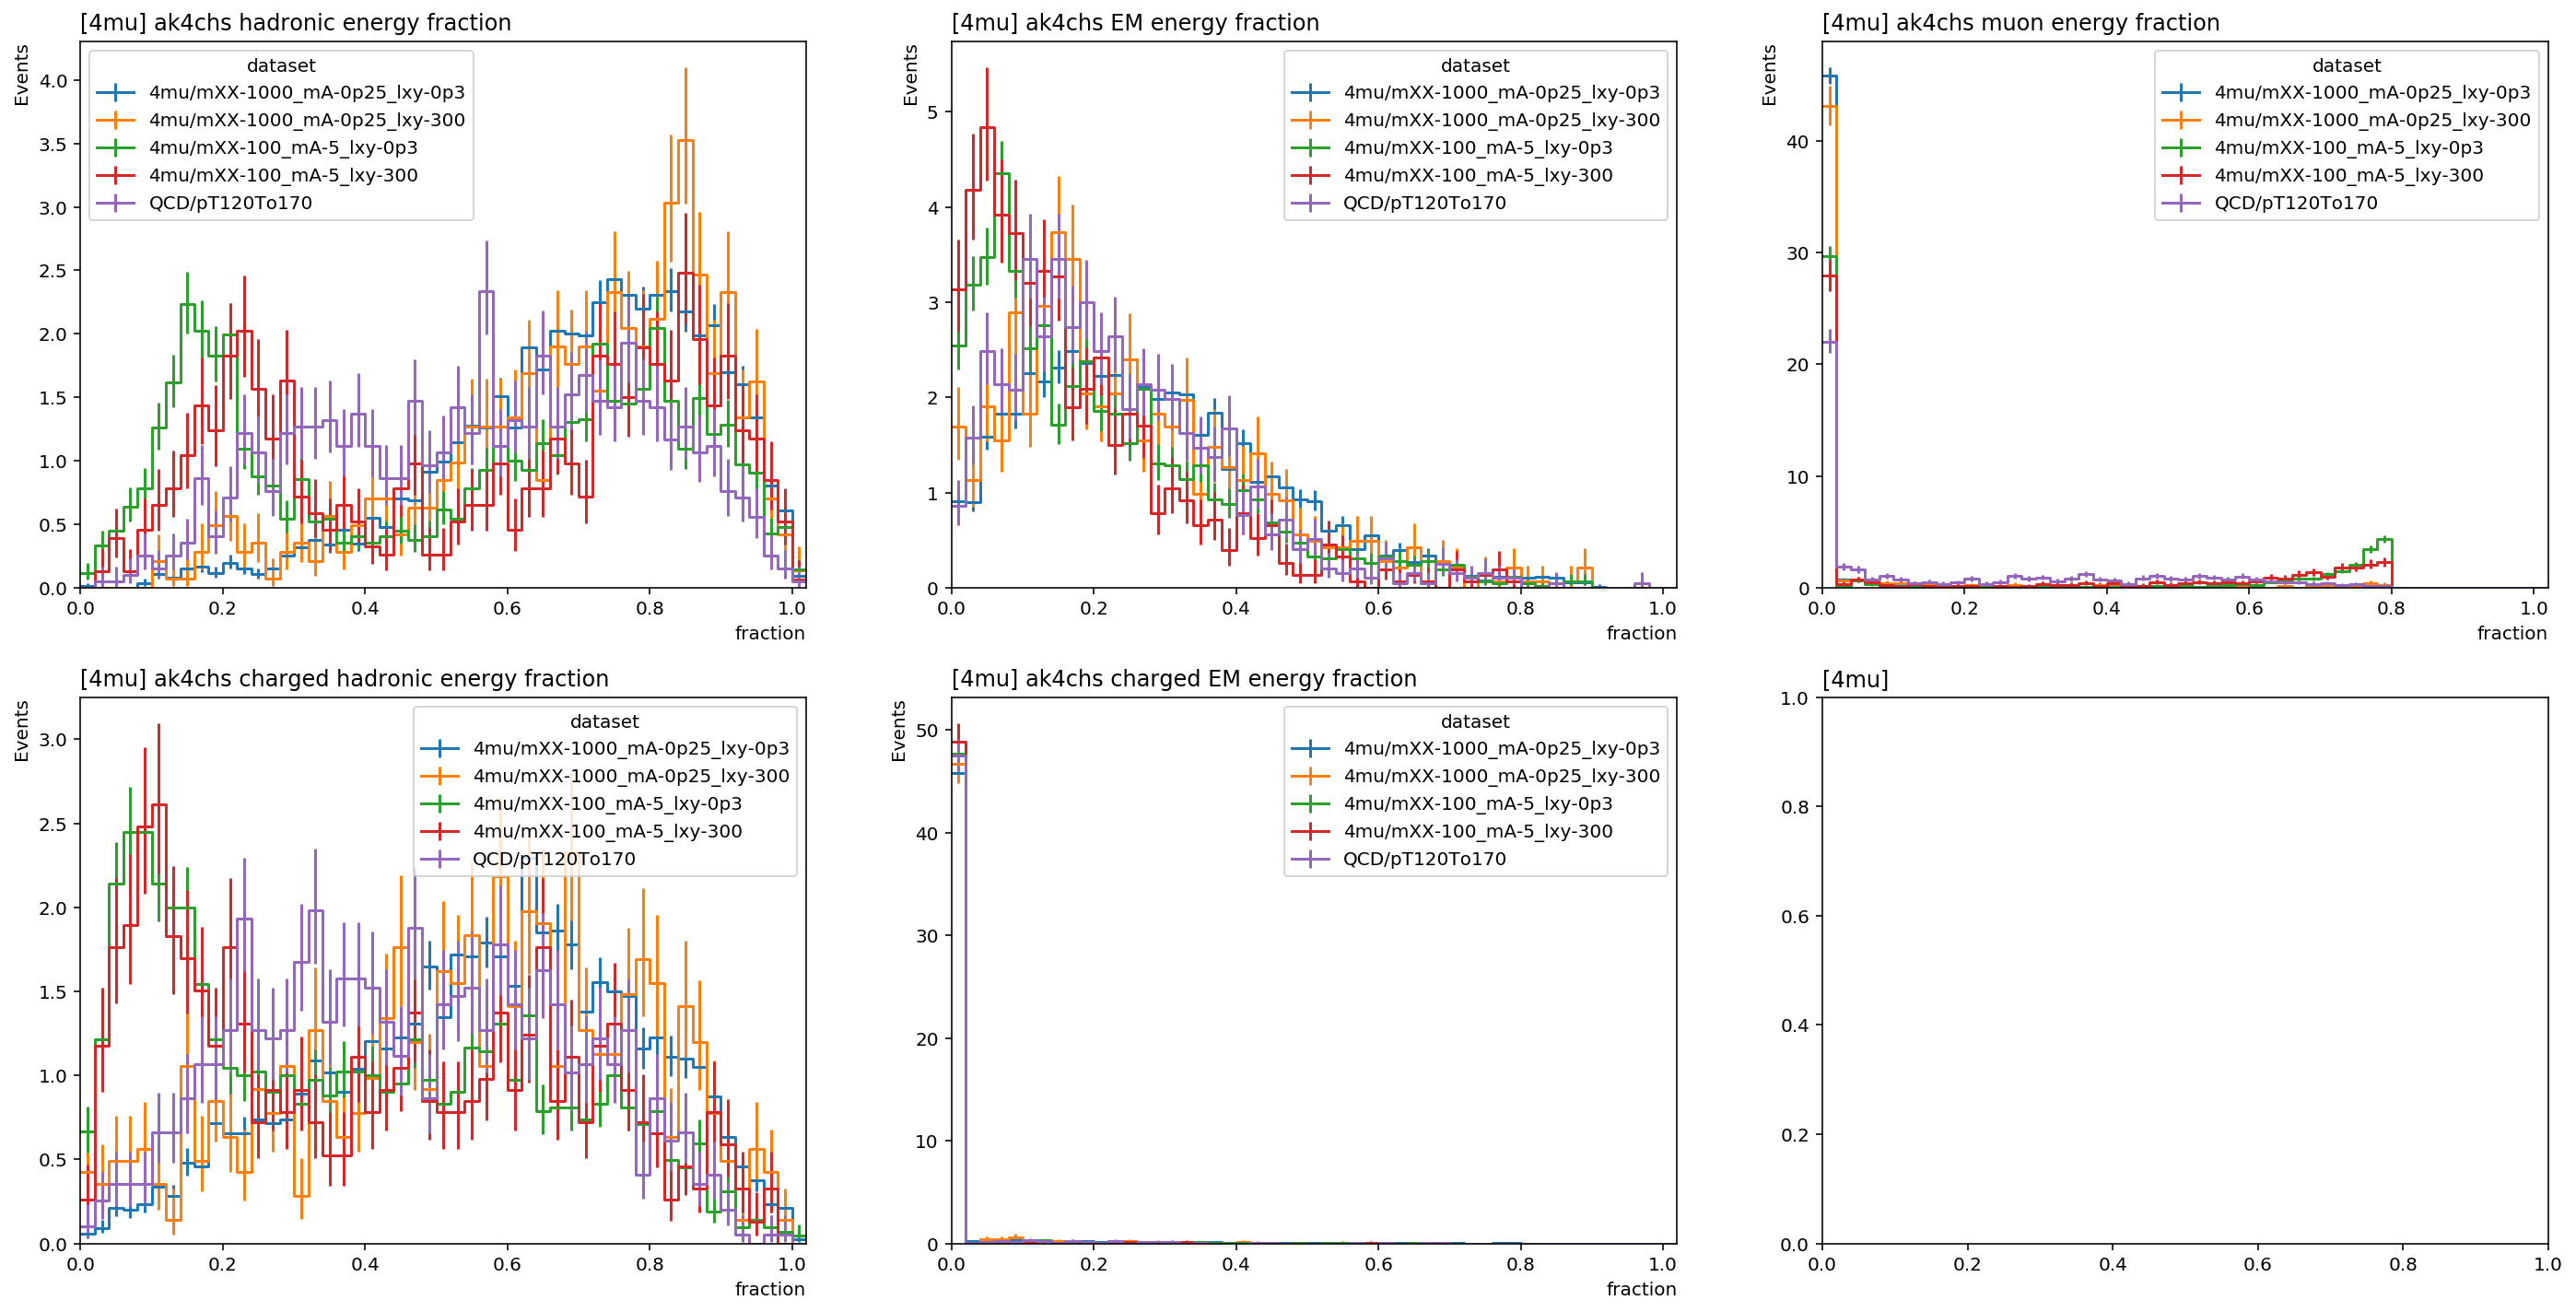

In [19]:
fig, axes = plt.subplots(2,3,figsize=(24,12))
hist.plot1d(output['hadfrac'].integrate('channel', '4mu'), overlay='dataset', ax=axes[0][0], overflow='over', density=True)
hist.plot1d(output['emfrac'].integrate('channel', '4mu'), overlay='dataset', ax=axes[0][1], overflow='over', density=True)
hist.plot1d(output['mufrac'].integrate('channel', '4mu'), overlay='dataset', ax=axes[0][2], overflow='over', density=True)
hist.plot1d(output['chadfrac'].integrate('channel', '4mu'), overlay='dataset', ax=axes[1][0], overflow='over', density=True)
hist.plot1d(output['cemfrac'].integrate('channel', '4mu'), overlay='dataset', ax=axes[1][1], overflow='over', density=True)

titles = [
    'ak4chs hadronic energy fraction',
    'ak4chs EM energy fraction',
    'ak4chs muon energy fraction',
    'ak4chs charged hadronic energy fraction',
    'ak4chs charged EM energy fraction',
    '',
]

for i, ax in enumerate(axes.flat):
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.set_title('[4mu] '+titles[i], ha='left', x=0)

- 2mu2e channel

In [40]:
dataset={
    '2mu2e/mXX-100_mA-5_lxy-0p3': dataset2mu2e_['mXX-100_mA-5_lxy-0p3'],
    '2mu2e/mXX-1000_mA-0p25_lxy-0p3': dataset2mu2e_['mXX-1000_mA-0p25_lxy-0p3'],
    '2mu2e/mXX-100_mA-5_lxy-300':dataset2mu2e_['mXX-100_mA-5_lxy-300'],
    '2mu2e/mXX-1000_mA-0p25_lxy-300': dataset2mu2e_['mXX-1000_mA-0p25_lxy-300'],
    'QCD/pT120To170': qcd_['QCD_Pt-120To170'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=ak4chsprocessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 144/144 [00:28<00:00,  5.04items/s]


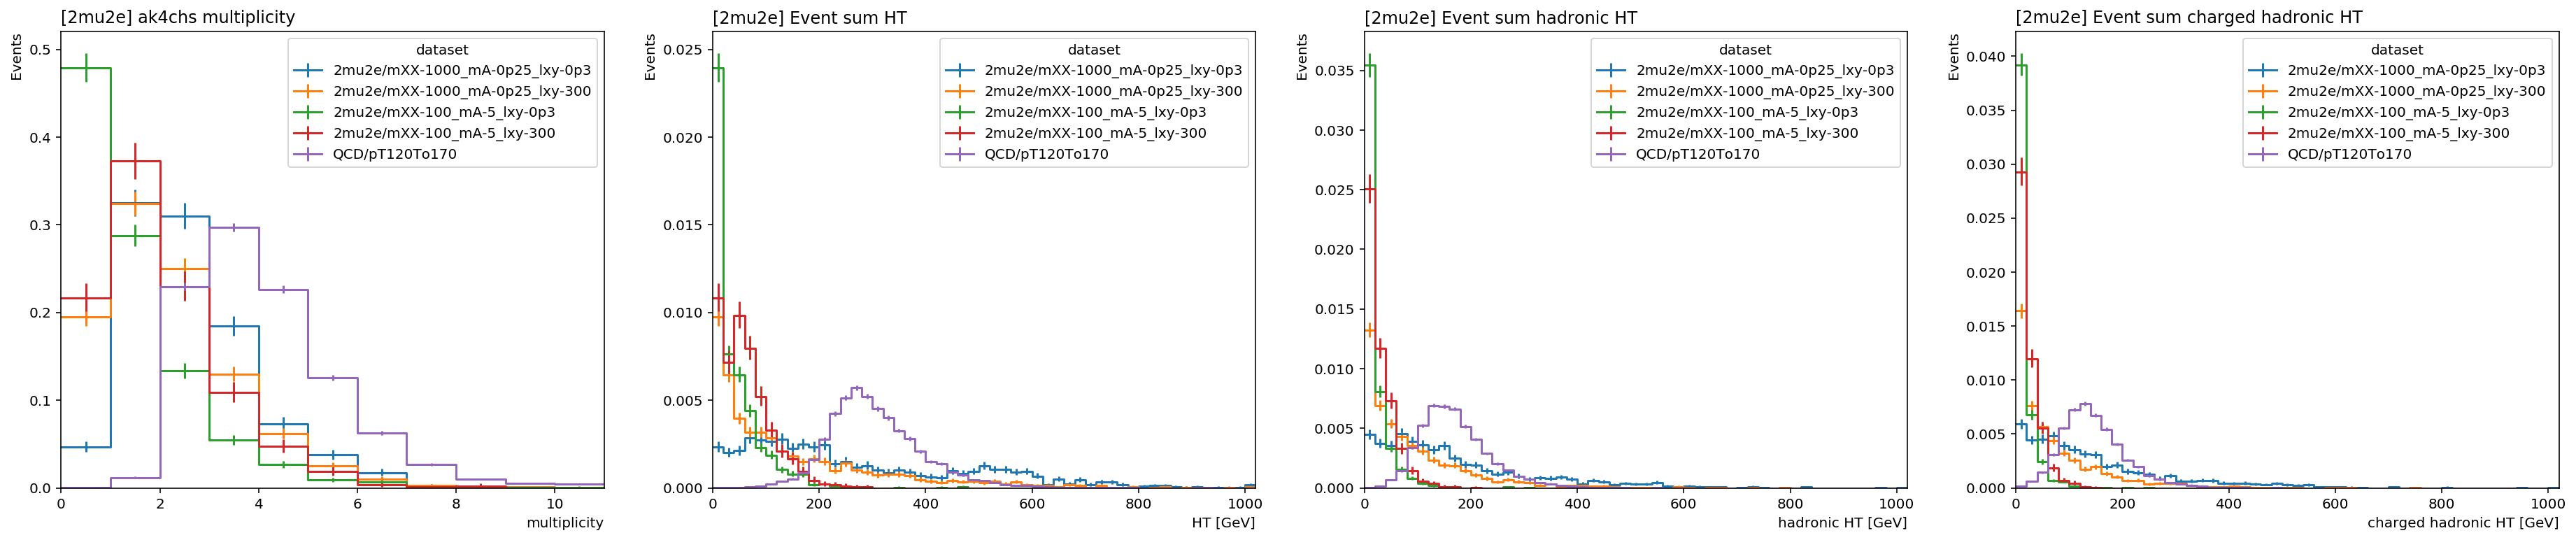

In [21]:
fig, axes = plt.subplots(1,4,figsize=(32,6))
hist.plot1d(output['multi'].integrate('channel', '2mu2e'), overlay='dataset', ax=axes[0], overflow='over', density=True)
# hist.plot1d(output['pt'], overlay='dataset', ax=axes[0][1], overflow='over', density=True)
# hist.plot1d(output['maxpt'], overlay='dataset', ax=axes[0][2], overflow='over', density=True)
hist.plot1d(output['ht'].integrate('channel', '2mu2e'), overlay='dataset', ax=axes[1], overflow='over', density=True)
hist.plot1d(output['hadht'].integrate('channel', '2mu2e'), overlay='dataset', ax=axes[2], overflow='over', density=True)
hist.plot1d(output['chahadht'].integrate('channel', '2mu2e'), overlay='dataset', ax=axes[3], overflow='over', density=True)

titles = [
    'ak4chs multiplicity',
#     'ak4chs $p_T$',
#     '3rd ak4chs $p_T$',
    'Event sum HT',
    'Event sum hadronic HT',
    'Event sum charged hadronic HT',
]
for i, ax in enumerate(axes.flat):
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.set_title('[2mu2e] '+titles[i], ha='left', x=0)

In [41]:
from collections import defaultdict
res = defaultdict(dict)
h = output['ak4chscut'].integrate('channel', '2mu2e')
for d in h.identifiers('dataset'):
    h_ = h.integrate('dataset', d)
    for c in h_.identifiers('minpt'):
        hh_ = h_.integrate('minpt', c)
        res[d][str(c)] = hh_.integrate('cut', slice(1,2)).values()[()]/hh_.integrate('cut').values()[()]*100
        res[d]['total'] = hh_.integrate('cut').values()[()]

import pandas as pd
df = pd.DataFrame(res).transpose()

df_ = df[['total', '20 GeV', '50 GeV', '100 GeV']]
df_.columns = ['total', '20 GeV (%)', '50 GeV (%)', '100 GeV (%)']
df_

,total,20 GeV (%),50 GeV (%),100 GeV (%)
2mu2e/mXX-1000_mA-0p25_lxy-0p3,1486.0,37.213997,72.543742,89.502019
2mu2e/mXX-1000_mA-0p25_lxy-300,1920.0,51.875000,84.062500,94.531250
2mu2e/mXX-100_mA-5_lxy-0p3,1873.0,76.668446,96.529632,99.893219
2mu2e/mXX-100_mA-5_lxy-300,910.0,58.901099,96.043956,100.000000
QCD/pT120To170,12090.0,1.199338,4.830438,47.105045


In [23]:
from collections import defaultdict
res = defaultdict(dict)
h = output['ht'].integrate('channel', '2mu2e')
for d in h.identifiers('dataset'):
    h_ = h.integrate('dataset', d)
    res[d]['total'] = h_.integrate('ht').values()[()]
    res[d]['200'] = h_.integrate('ht', slice(0,200)).values()[()]
    res[d]['250'] = h_.integrate('ht', slice(0,250)).values()[()]
import pandas as pd
df = pd.DataFrame(res).transpose()
df['eff@200'] = df['200']/df['total']
df['eff@250'] = df['250']/df['total']
df

/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/hist/hist_tools.py:477: RuntimeWarning: Reducing along axis <Bin (name=ht) instance at 0x7f3614685780>: requested stop 250 between bin boundaries, no interpolation is performed
  RuntimeWarning)


,200,250,total,eff@200,eff@250
2mu2e/mXX-1000_mA-0p25_lxy-0p3,732.0,891.0,1481.0,0.494261,0.601621
2mu2e/mXX-1000_mA-0p25_lxy-300,1399.0,1549.0,1918.0,0.729406,0.807612
2mu2e/mXX-100_mA-5_lxy-0p3,1851.0,1865.0,1873.0,0.988254,0.995729
2mu2e/mXX-100_mA-5_lxy-300,899.0,908.0,910.0,0.987912,0.997802
QCD/pT120To170,925.0,3864.0,12090.0,0.076510,0.319603


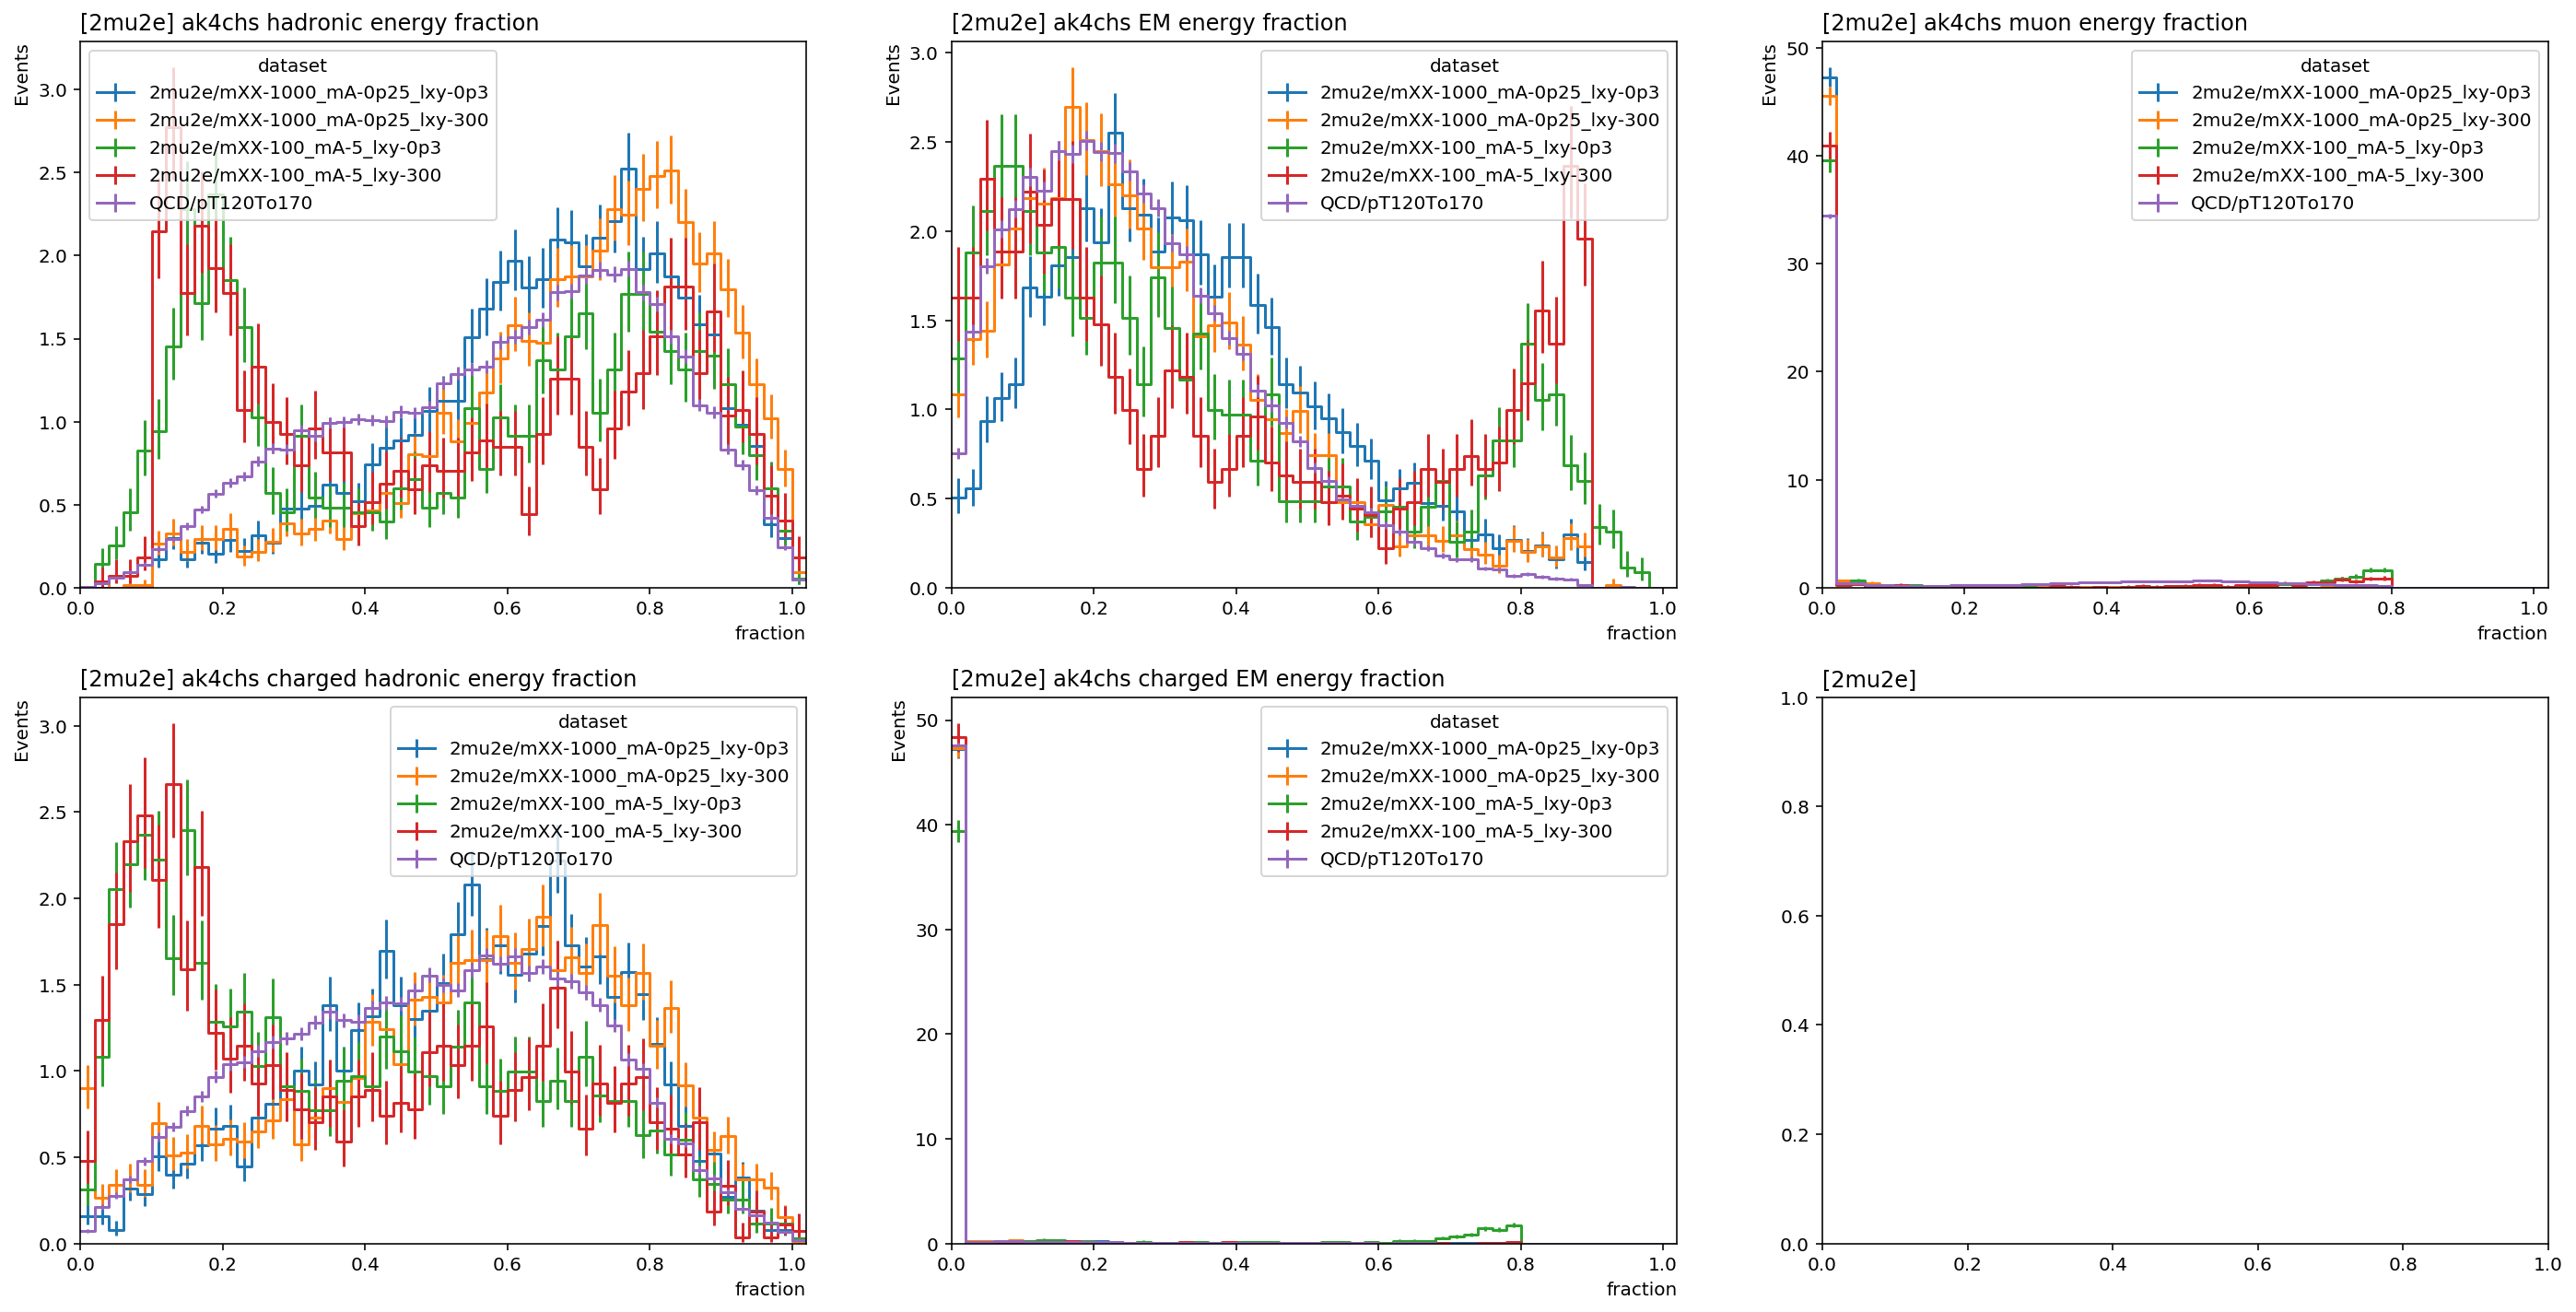

In [24]:
fig, axes = plt.subplots(2,3,figsize=(24,12))
hist.plot1d(output['hadfrac'].integrate('channel', '2mu2e'), overlay='dataset', ax=axes[0][0], overflow='over', density=True)
hist.plot1d(output['emfrac'].integrate('channel', '2mu2e'), overlay='dataset', ax=axes[0][1], overflow='over', density=True)
hist.plot1d(output['mufrac'].integrate('channel', '2mu2e'), overlay='dataset', ax=axes[0][2], overflow='over', density=True)
hist.plot1d(output['chadfrac'].integrate('channel', '2mu2e'), overlay='dataset', ax=axes[1][0], overflow='over', density=True)
hist.plot1d(output['cemfrac'].integrate('channel', '2mu2e'), overlay='dataset', ax=axes[1][1], overflow='over', density=True)

titles = [
    'ak4chs hadronic energy fraction',
    'ak4chs EM energy fraction',
    'ak4chs muon energy fraction',
    'ak4chs charged hadronic energy fraction',
    'ak4chs charged EM energy fraction',
    '',
]

for i, ax in enumerate(axes.flat):
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.set_title('[2mu2e] '+titles[i], ha='left', x=0)

# overlapping btw. ak4chs and leptonjets

In [121]:
class overlapProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        channel_axis = hist.Cat('channel', 'channel')
        overlap_axis = hist.Bin('overlap', 'overlapped', 2, 0, 2)
        self._accumulator = processor.dict_accumulator({
            'overlapak4': hist.Hist('Counts', dataset_axis, channel_axis, overlap_axis),
            'overlaplj': hist.Hist('Counts', dataset_axis, channel_axis, overlap_axis),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset=df['dataset']
        
        ak4chs = JaggedCandidateArray.candidatesfromcounts(
            df['akjet_p4'],
            px=df['akjet_p4.fCoordinates.fX'],
            py=df['akjet_p4.fCoordinates.fY'],
            pz=df['akjet_p4.fCoordinates.fZ'],
            energy=df['akjet_p4.fCoordinates.fT'],
            jetid=df['akjet_jetid'],
        )
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        nmu = ((ljdautype==3)|(ljdautype==8)).sum()
        leptonjets.add_attributes(ismutype=(nmu>=2), iseltype=(nmu==0))
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        twomujets = dileptonjets.ismutype.sum()==2
        leadinglj = dileptonjets[dileptonjets.pt.argmax()]
        subleadinglj = dileptonjets[dileptonjets.pt.argsort()[:, 1:2]]
        fourMuChannel = twomujets&(leadinglj.ismutype.flatten())&(subleadinglj.ismutype.flatten())
        
        onemujets = dileptonjets.ismutype.sum()==1
        twoMuTwoEChannel = onemujets&(leadinglj.ismutype.flatten()|subleadinglj.ismutype.flatten())
        ak4chs=ak4chs[twoleptonjets]
        ak4chs=ak4chs[(ak4chs.pt>20)&(ak4chs.jetid)]
        
        ljmatchmask = dileptonjets.match(ak4chs, deltaRCut=0.8)
        ak4matchmask = ak4chs.match(dileptonjets, deltaRCut=0.8)
        
        output['overlapak4'].fill(dataset=dataset,
                                  channel='4mu',
                                  overlap=ak4matchmask[fourMuChannel].astype(int).flatten()
                                 )
        output['overlapak4'].fill(dataset=dataset,
                                  channel='2mu2e',
                                  overlap=ak4matchmask[twoMuTwoEChannel].astype(int).flatten()
                                 )
        output['overlaplj'].fill(dataset=dataset,
                                  channel='4mu',
                                  overlap=ljmatchmask[fourMuChannel].astype(int).flatten()
                                 )
        output['overlaplj'].fill(dataset=dataset,
                                  channel='2mu2e',
                                  overlap=ljmatchmask[twoMuTwoEChannel].astype(int).flatten()
                                 )
        return output
    def postprocess(self, accumulator):
        return accumulator

- 4mu channel

In [122]:
dataset={
    '4mu/mXX-100_mA-5_lxy-0p3': dataset4mu_['mXX-100_mA-5_lxy-0p3'],
    '4mu/mXX-1000_mA-0p25_lxy-0p3': dataset4mu_['mXX-1000_mA-0p25_lxy-0p3'],
    '4mu/mXX-100_mA-5_lxy-300': dataset4mu_['mXX-100_mA-5_lxy-300'],
    '4mu/mXX-1000_mA-0p25_lxy-300': dataset4mu_['mXX-1000_mA-0p25_lxy-300'],
}

output = processor.run_uproot_job(dataset,
                                  treename="ffNtuplizer/ffNtuple",
                                  processor_instance=overlapProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:06<00:00,  3.32items/s]


In [123]:
from collections import defaultdict
import pandas as pd

res = defaultdict(dict)
h = output['overlapak4'].integrate('channel', '4mu')
for d in h.identifiers('dataset'):
    h_ = h.integrate('dataset', d)
    res[d]['total'] = h_.integrate('overlap').values()[()]
    res[d]['overlap ratio %'] = h_.integrate('overlap', slice(1,2)).values()[()]/h_.integrate('overlap').values()[()]*100
df = pd.DataFrame(res).transpose()
print('AK4CHS')
display(df)

res = defaultdict(dict)
h = output['overlaplj'].integrate('channel', '4mu')
for d in h.identifiers('dataset'):
    h_ = h.integrate('dataset', d)
    res[d]['total'] = h_.integrate('overlap').values()[()]
    res[d]['overlap ratio %'] = h_.integrate('overlap', slice(1,2)).values()[()]/h_.integrate('overlap').values()[()]*100
df = pd.DataFrame(res).transpose()
print('leptonjet')
display(df)

AK4CHS


,overlap ratio %,total
4mu/mXX-1000_mA-0p25_lxy-0p3,7.393043,16502.0
4mu/mXX-1000_mA-0p25_lxy-300,9.446131,2636.0
4mu/mXX-100_mA-5_lxy-0p3,8.987976,9980.0
4mu/mXX-100_mA-5_lxy-300,11.391606,3169.0


leptonjet


,overlap ratio %,total
4mu/mXX-1000_mA-0p25_lxy-0p3,15.189384,7762.0
4mu/mXX-1000_mA-0p25_lxy-300,21.321586,1135.0
4mu/mXX-100_mA-5_lxy-0p3,17.925710,4792.0
4mu/mXX-100_mA-5_lxy-300,28.248588,1239.0


- 2mu2e channel

In [124]:
dataset={
    '2mu2e/mXX-100_mA-5_lxy-0p3': dataset2mu2e_['mXX-100_mA-5_lxy-0p3'],
    '2mu2e/mXX-1000_mA-0p25_lxy-0p3': dataset2mu2e_['mXX-1000_mA-0p25_lxy-0p3'],
    '2mu2e/mXX-100_mA-5_lxy-300':dataset2mu2e_['mXX-100_mA-5_lxy-300'],
    '2mu2e/mXX-1000_mA-0p25_lxy-300': dataset2mu2e_['mXX-1000_mA-0p25_lxy-300'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=overlapProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:06<00:00,  3.32items/s]


In [125]:
from collections import defaultdict
import pandas as pd

res = defaultdict(dict)
h = output['overlapak4'].integrate('channel', '2mu2e')
for d in h.identifiers('dataset'):
    h_ = h.integrate('dataset', d)
    res[d]['total'] = h_.integrate('overlap').values()[()]
    res[d]['overlap ratio %'] = h_.integrate('overlap', slice(1,2)).values()[()]/h_.integrate('overlap').values()[()]*100
df = pd.DataFrame(res).transpose()
print('AK4CHS')
display(df)

res = defaultdict(dict)
h = output['overlaplj'].integrate('channel', '2mu2e')
for d in h.identifiers('dataset'):
    h_ = h.integrate('dataset', d)
    res[d]['total'] = h_.integrate('overlap').values()[()]
    res[d]['overlap ratio %'] = h_.integrate('overlap', slice(1,2)).values()[()]/h_.integrate('overlap').values()[()]*100
df = pd.DataFrame(res).transpose()
print('leptonjet')
display(df)

AK4CHS


,overlap ratio %,total
2mu2e/mXX-1000_mA-0p25_lxy-0p3,20.910759,8718.0
2mu2e/mXX-1000_mA-0p25_lxy-300,13.573740,10815.0
2mu2e/mXX-100_mA-5_lxy-0p3,9.234796,8024.0
2mu2e/mXX-100_mA-5_lxy-300,16.655752,4581.0


leptonjet


,overlap ratio %,total
2mu2e/mXX-1000_mA-0p25_lxy-0p3,52.926679,3246.0
2mu2e/mXX-1000_mA-0p25_lxy-300,32.716927,4218.0
2mu2e/mXX-100_mA-5_lxy-0p3,18.868421,3800.0
2mu2e/mXX-100_mA-5_lxy-300,40.684411,1841.0


# apply leptonjet cleaning

In [131]:
class leptonjetcleaningProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        channel_axis = hist.Cat('channel', 'channel')
        multi_axis = hist.Bin('multi', 'multiplicity', 20, 0, 20)
        pt_axis = hist.Bin('pt', 'pT', 50, 0, 500)
        self._accumulator = processor.dict_accumulator({
            'nak4': hist.Hist('Counts', dataset_axis, channel_axis, multi_axis),
            'ak4pt': hist.Hist('Counts', dataset_axis, channel_axis, pt_axis),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset=df['dataset']
        
        ak4chs = JaggedCandidateArray.candidatesfromcounts(
            df['akjet_p4'],
            px=df['akjet_p4.fCoordinates.fX'],
            py=df['akjet_p4.fCoordinates.fY'],
            pz=df['akjet_p4.fCoordinates.fZ'],
            energy=df['akjet_p4.fCoordinates.fT'],
            jetid=df['akjet_jetid'],
        )
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        nmu = ((ljdautype==3)|(ljdautype==8)).sum()
        leptonjets.add_attributes(ismutype=(nmu>=2), iseltype=(nmu==0))
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        twomujets = dileptonjets.ismutype.sum()==2
        leadinglj = dileptonjets[dileptonjets.pt.argmax()]
        subleadinglj = dileptonjets[dileptonjets.pt.argsort()[:, 1:2]]
        fourMuChannel = twomujets&(leadinglj.ismutype.flatten())&(subleadinglj.ismutype.flatten())
        
        onemujets = dileptonjets.ismutype.sum()==1
        twoMuTwoEChannel = onemujets&(leadinglj.ismutype.flatten()|subleadinglj.ismutype.flatten())
        ak4chs=ak4chs[twoleptonjets]
        
        ak4chs=ak4chs[(ak4chs.pt>20)]
        
#         ljmatchmask = dileptonjets.match(ak4chs, deltaRCut=0.4)
        ak4matchmask = ak4chs.match(dileptonjets, deltaRCut=0.8)
#         print((~ljmatchmask)[fourMuChannel].counts)
        
        output['nak4'].fill(dataset=dataset,
                            channel='4mu',
                            multi=(~ak4matchmask)[fourMuChannel].astype(int).sum()
                            )
        output['ak4pt'].fill(dataset=dataset,
                            channel='4mu',
                             pt=ak4chs[~ak4matchmask][fourMuChannel].pt.sum()
                            )
        output['nak4'].fill(dataset=dataset,
                            channel='2mu2e',
                            multi=(~ak4matchmask)[twoMuTwoEChannel].astype(int).sum()
                            )
        output['ak4pt'].fill(dataset=dataset,
                            channel='2mu2e',
                             pt=ak4chs[~ak4matchmask][fourMuChannel].pt.sum()
                            )
        return output
    def postprocess(self, accumulator):
        return accumulator

- 4mu channel

In [132]:
dataset={
    '4mu/mXX-100_mA-5_lxy-0p3': dataset4mu_['mXX-100_mA-5_lxy-0p3'],
    '4mu/mXX-1000_mA-0p25_lxy-0p3': dataset4mu_['mXX-1000_mA-0p25_lxy-0p3'],
    '4mu/mXX-100_mA-5_lxy-300': dataset4mu_['mXX-100_mA-5_lxy-300'],
    '4mu/mXX-1000_mA-0p25_lxy-300': dataset4mu_['mXX-1000_mA-0p25_lxy-300'],
    'QCD/pT120To170': qcd_['QCD_Pt-120To170'],
}

output = processor.run_uproot_job(dataset,
                                  treename="ffNtuplizer/ffNtuple",
                                  processor_instance=leptonjetcleaningProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 144/144 [00:19<00:00,  7.73items/s]


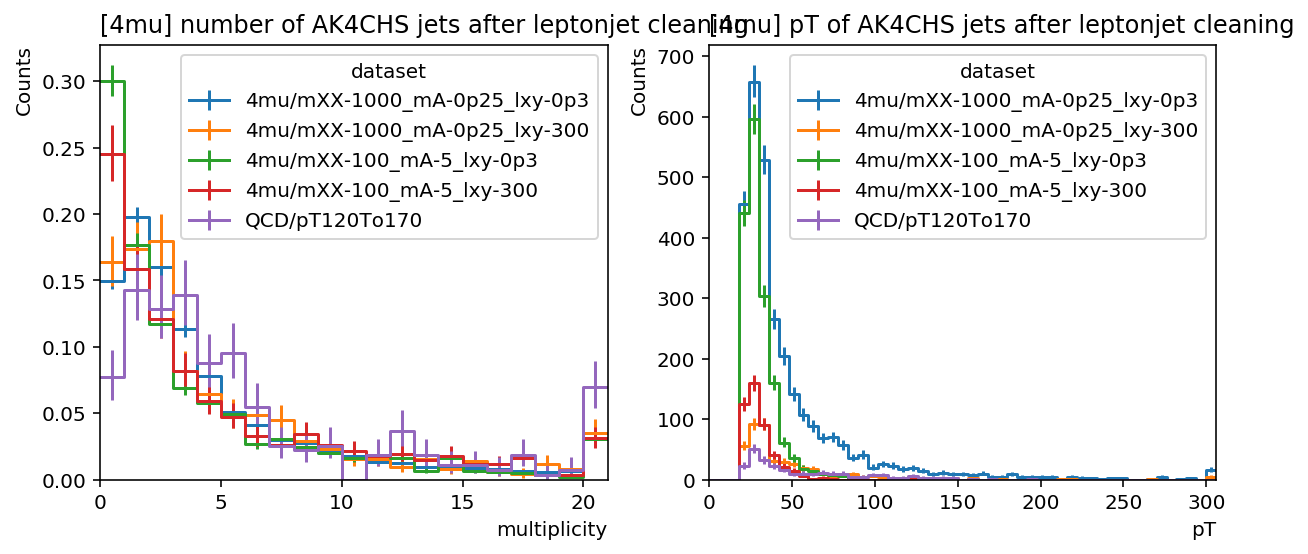

In [128]:
fit, axes = plt.subplots(1,2,figsize=(10,4))
hist.plot1d(output['nak4'].integrate('channel', '4mu'), overlay='dataset', ax=axes[0], overflow='over',density=True)
hist.plot1d(output['ak4pt'].integrate('channel', '4mu'), overlay='dataset', ax=axes[1], overflow='over',density=False)

axes[0].set_title('[4mu] number of AK4CHS jets after leptonjet cleaning', ha='left', x=0)
axes[1].set_title('[4mu] pT of AK4CHS jets after leptonjet cleaning', ha='left', x=0)
for ax in axes:
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

- 2mu2e channel

In [129]:
dataset={
    '2mu2e/mXX-100_mA-5_lxy-0p3': dataset2mu2e_['mXX-100_mA-5_lxy-0p3'],
    '2mu2e/mXX-1000_mA-0p25_lxy-0p3': dataset2mu2e_['mXX-1000_mA-0p25_lxy-0p3'],
    '2mu2e/mXX-100_mA-5_lxy-300':dataset2mu2e_['mXX-100_mA-5_lxy-300'],
    '2mu2e/mXX-1000_mA-0p25_lxy-300': dataset2mu2e_['mXX-1000_mA-0p25_lxy-300'],
    'QCD/pT120To170': qcd_['QCD_Pt-120To170'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=leptonjetcleaningProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 144/144 [00:20<00:00,  7.17items/s]


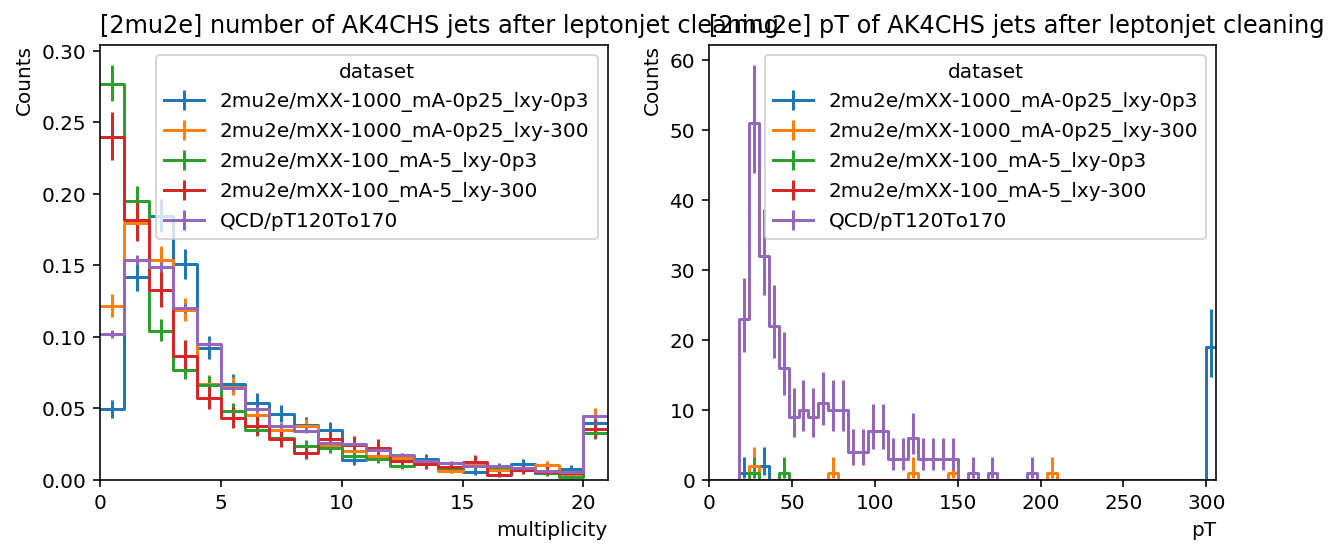

In [130]:
fit, axes = plt.subplots(1,2,figsize=(10,4))
hist.plot1d(output['nak4'].integrate('channel', '2mu2e'), overlay='dataset', ax=axes[0], overflow='over',density=True)
hist.plot1d(output['ak4pt'].integrate('channel', '2mu2e'), overlay='dataset', ax=axes[1], overflow='over',density=False)

axes[0].set_title('[2mu2e] number of AK4CHS jets after leptonjet cleaning', ha='left', x=0)
axes[1].set_title('[2mu2e] pT of AK4CHS jets after leptonjet cleaning', ha='left', x=0)
for ax in axes:
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");